# SuperFish [ 8/1/2025 ]
implemented full space charge solves - CN

### TODOS:
- When CST_flag is on, make it such that particles that hit the wall are no longer binned
- 3D binning of the particles

### FIXMES:
- Has a fudge factor of around 4. Fix this by doing the 3d binning. If it is not fixed, then something else is amiss.

## Method and Code Breakdown
Let's assume axisymmetric fields, i.e $\partial_{\theta} E_{\theta} = 0$, and time harmonic variation, i.e $E(\vec{r},t) = \tilde{E}(\vec{r})\cos(\omega t + \phi_{\text{RF}})$, $B(\vec{r},t) = \tilde{B}(\vec{r})\cos(\omega t + \phi_{\text{RF}})$. Then, from Gauss' Law
$$ \nabla \cdot \tilde{E} = 0 \implies \partial_{z}\tilde{E}_{z} + r^{-1}\partial_{r}r \tilde{E}_{r} = 0.$$
Or,
$$ r\tilde{E}_{r} = -\frac{r^{2}}{2}\partial_{z}\tilde{E}_{z} \implies \tilde{E}_{r} = -\frac{r}{2}\partial_{z}\tilde{E}_{z} = -\frac{r}{2}\tilde{E}_{z}'.$$
From Ampere's Law in frequency domain (with no free currents),
$$ \nabla\times \tilde{B} = j\omega\mu_{0}\epsilon_{0} \tilde{E} \implies r^{-1}\partial_{r} r B_{\theta} = j\omega c^{-2}E_{z}.$$
Or,
$$ B_{\theta} = j\omega\frac{r}{2 c^{2}} E_{z}.$$
Since, $E_{z} = \tilde{E}_{z}\cos(\omega t + \phi_{\text{RF}})$,
$$ B_{\theta} = -\frac{r\omega}{2 c^{2}}\tilde{E}_{z}\sin(\omega t + \phi_{\text{RF}}).$$
Loading in $E_{z}$ from CST, computing $E_{r}$, $B_{\theta}$ and computing $B_{x},B_{y},E_{x},E_{y}$ through
$$ E_{z} = \tilde{E}_{z}\cos(\omega t + \phi_{RF})$$
$$ E_{r} = -\frac{r}{2}\tilde{E}_{z}'\cos(\omega t + \phi_{RF})$$
$$ B_{\theta} = -\frac{\omega r}{2c^{2}}\tilde{E}_{z}\sin(\omega t + \phi_{RF})$$

Note: This saves on memory since I only have to export $\tilde{E}_{z}$ from CST, but I could theoretically spit out $\textbf{all}$ of the fields and use it on a cavity without nice symmetries as well.

## Import Block

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
from numpy.linalg import norm
from scipy.interpolate import RegularGridInterpolator
from numba import njit

from tqdm import tqdm

#space charge solver
import spacecharge as sc

mpl.rcParams['axes.linewidth'] = 1.2

## Constants

In [2]:
EPSILON_0 = 8.85E-12
COULOMB_K = 1 / (4 * np.pi * EPSILON_0)
c = 3E8
q = 1.6e-19                                    # Proton charge
me = 9.1e-31                                   # Electron mass

L = 4.13*0.0254                                # Length scale in m (set this to overall beamtube length or similar)
sigma_x = 0.001                                # Beam radius std deviation
r_c = 0.0375                                   # Not used
sigma_u = 0.001                                # std deviation in initial momentum
beam_pos_shift = np.array([0,0.038,0.038])     # Beam position shift (not used)

## Handy Field Conversions

## File IO

In [3]:
def inputSuperfishfields(fname):
    with open(fname) as fin:
        lines = fin.readlines()
        linesplit = [lines[i].split() for i in range(len(lines))]
        Zmin = float(linesplit[0][0])/100
        Zmax = float(linesplit[0][1])/100
        Nz = int(linesplit[0][2])
        freq = float(linesplit[1][0])*1e6
        Rmin = float(linesplit[2][0])/100
        Rmax = float(linesplit[2][1])/100
        Nr = int(linesplit[2][2])
    rr = np.linspace(Rmin,Rmax,Nr+1,endpoint=True)
    zz = np.linspace(Zmin,Zmax,Nz+1,endpoint=True)

    print(Zmin, Zmax, Nz, Rmin, Rmax, Nr)

    E = np.zeros([Nz+1,Nr+1,2])
    Emag = np.zeros([Nz+1,Nr+1])
    Bt = np.zeros([Nz+1,Nr+1])

    linesplitE = linesplit[4::2]
    linesplitB = linesplit[5::2]

    for ind in range(len(linesplitE)):
        i = ind % (Nz+1)
        j = int(ind / (Nz+1)) - 1
        E[i,j,0] = float(linesplitE[ind][0])*1e6
        E[i,j,1] = float(linesplitE[ind][1])*1e6
        Emag[i,j] = float(linesplitE[ind][2])*1e6
        Bt[i,j] = float(linesplitB[ind][0])*4e-7*np.pi

    ## Chris -- Here's a little assignment to work on when you get a second
    # The 'RegularGridInterpolator' function in scipy basically takes discrete data, i.e E[:,:,0/1]
    # and converts it into a function that can spit out the right fields at any (z,r).
    # Write a custom function that does this using only basic numpy operations and python primitives.
    # We're eventually going to use numba to speed it up (and parallelize with MPI/CUDA down the line).
    return E, Bt, rr, zz, Emag

E, Bt, rr, zz, Emag  = inputSuperfishfields("1T1.T7")

zmax = np.max(zz)
zmin = np.min(zz)
rmin = np.min(rr)
rmax = np.max(rr)
Nz = len(zz)
Nr = len(rr)

dz = zz[1] - zz[0]
dr = rr[1] - rr[0]

Ez = E[:,:,0].transpose()
Er = E[:,:,1].transpose()
Bt = Bt.transpose()

    
@njit(fastmath=True)
def EZint(r):
    R = np.sqrt(r[0]**2 + r[1]**2)
    Z = r[-1]

    if ((R > rmax) or (R < rmin)):
        #print(R, rmin, rmax)
        return 0
    if ((Z > zmax) or (Z < zmin)):
        #print(Z, zmin, zmax)
        return 0

    const = 1.0/(dr*dz)

    indz = int(Z/dz)
    indr = int(R/dr)

    f = np.zeros(4)
    w = np.zeros(4)

    f[0] = Ez[indr,indz]
    f[1] = Ez[indr,indz+1]
    f[2] = Ez[indr+1,indz]
    f[3] = Ez[indr+1,indz+1]

    w[0] = (rr[indr+1]-R)*(zz[indz+1]-Z)
    w[1] = (rr[indr+1]-R)*(Z-zz[indz])
    w[2] = (R-rr[indr])*(zz[indz+1]-Z)
    w[3] = (R-rr[indr])*(Z-zz[indz])

    return np.sum(f*w)*const

@njit(fastmath=True)
def ERint(r):
    R = np.sqrt(r[0]**2 + r[1]**2)
    Z = r[-1]

    if ((R > rmax) or (R < rmin)):
        #print(R, rmin, rmax)
        return 0
    if ((Z > zmax) or (Z < zmin)):
        #print(Z, zmin, zmax)
        return 0

    dzp = dz/100
    Ezp = (EZint(r+np.array([0,0,dzp])) - EZint(r))/dzp

    return -R/2*Ezp

@njit(fastmath=True)
def BTint(r):
    R = np.sqrt(r[0]**2 + r[1]**2)
    Z = r[-1]

    if ((R > rmax) or (R < rmin)):
        #print(R, rmin, rmax)
        return 0
    if ((Z > zmax) or (Z < zmin)):
        #print(Z, zmin, zmax)
        return 0

    const = 1.0/(dr*dz)

    indz = int(Z/dz)
    indr = int(R/dr)

    f = np.zeros(4)
    w = np.zeros(4)


    f[0] = Bt[indr,indz]
    f[1] = Bt[indr,indz+1]
    f[2] = Bt[indr+1,indz]
    f[3] = Bt[indr+1,indz+1]

    w[0] = (rr[indr+1]-R)*(zz[indz+1]-Z)
    w[1] = (rr[indr+1]-R)*(Z-zz[indz])
    w[2] = (R-rr[indr])*(zz[indz+1]-Z)
    w[3] = (R-rr[indr])*(Z-zz[indz])

    return -omega*R/(2*c**2)*EZint(r)

@njit(fastmath=True)
def Exint(r):
    th = math.atan2(r[1],r[0])
    return ERint(r)*np.cos(th)

@njit(fastmath=True)
def Eyint(r):
    th = math.atan2(r[1],r[0])

    return ERint(r)*np.sin(th)

@njit(fastmath=True)
def Ezint(r):
    return EZint(r)

@njit(fastmath=True)
def Bxint(r):
    th = math.atan2(r[1],r[0])

    return -BTint(r)*np.sin(th)

@njit(fastmath=True)
def Byint(r):
    th = math.atan2(r[1],r[0])

    return BTint(r)*np.cos(th)
def inputCSTfields_2files(efldname,bfldname,Nx,Ny,Nz,usesInches=True):
    x = np.loadtxt(efldname)
    if usesInches == True:
        x[:,:3]*=0.0254

    xshift = -np.array([0,0,0]) #x[0,1],x[0,2]])
    # X = x[:,:3]

    Rmat = np.sqrt((x[:,0]-xshift[0])**2+(x[:,1]-xshift[1])**2)
    costhmat = (x[:,0]-xshift[0])/Rmat
    sinthmat = (x[:,1]-xshift[1])/Rmat

    Rmat = Rmat.reshape([Nz,Ny,Nx])
    costhmat = costhmat.reshape([Nz,Ny,Nx])
    sinthmat = sinthmat.reshape([Nz,Ny,Nx])

    xx = x[:,0].reshape([Nz,Ny,Nx])
    yy = x[:,1].reshape([Nz,Ny,Nx])
    zz = x[:,2].reshape([Nz,Ny,Nx])
    # xx = xx_tmp[0,0]
    # yy = yy_tmp[0,:,0]
    # zz = zz_tmp[:,0,0]
    # dz = zz[1,0,0]-zz[0,0,0]
    Ez = x[:,7].reshape([Nz,Ny,Nx]).transpose(2,1,0)
    Ey = x[:,5].reshape([Nz,Ny,Nx]).transpose(2,1,0)
    Ex = x[:,3].reshape([Nz,Ny,Nx]).transpose(2,1,0)
    print(np.max(np.sqrt((x[:,3])**2 + (x[:,5])**2 + (x[:,7])**2))*Amp_fac)
    print(np.max(np.abs(x[:,7])*Amp_fac)*2*np.cos(2*np.pi*f_res/c*2.85e-3)/(2*np.pi*f_res/c))

    #plt.pcolormesh(yy[:,:,10],zz[:,:,10],abs(sinthmat[:,:,10]))
    #print(dz)
    #print(xx[10,:,:])

    # Er = np.zeros([Nz,Ny,Nx])
    #print(np.shape(Rmat),np.shape(Ez))
    #Er[1:-1,:,:] = -0.5*Rmat[1:-1,:,:]*(Ez[2:,:,:]-Ez[:-2,:,:])/(2*dz)
    # plt.plot(yy[43,:,16],sinthmat[43,:,16])

    x = np.loadtxt(bfldname)
    if usesInches == True:
        x[:,:3]*=0.0254

    xshift = -np.array([0,0,0]) #x[0,1],x[0,2]])
    # X = x[:,:3]
    Rmat = np.sqrt((x[:,0]-xshift[0])**2+(x[:,1]-xshift[1])**2)
    costhmat = (x[:,0]-xshift[0])/Rmat
    sinthmat = (x[:,1]-xshift[1])/Rmat

    Rmat = Rmat.reshape([Nz,Ny,Nx])
    costhmat = costhmat.reshape([Nz,Ny,Nx])
    sinthmat = sinthmat.reshape([Nz,Ny,Nx])

    xx = x[:,0].reshape([Nz,Ny,Nx])
    yy = x[:,1].reshape([Nz,Ny,Nx])
    zz = x[:,2].reshape([Nz,Ny,Nx])
    #xx = xx_tmp[0,0]
    #yy = yy_tmp[0,:,0]
    #zz = zz_tmp[:,0,0]
    dz = zz[1,0,0]-zz[0,0,0]
    Bz = x[:,7].reshape([Nz,Ny,Nx]).transpose(2,1,0)*4e-7*np.pi
    By = x[:,5].reshape([Nz,Ny,Nx]).transpose(2,1,0)*4e-7*np.pi
    Bx = x[:,3].reshape([Nz,Ny,Nx]).transpose(2,1,0)*4e-7*np.pi
    #plt.colorbar()

    #Er = costhmat*Ex + sinthmat*Ey
    #Btheta = -0.5*Rmat*omega/c**2*Ez
    #Bx = -Btheta*sinthmat
    #By = Btheta*costhmat
    #Ex = Er*costhmat
    #Ey = Er*sinthmat

    plt.figure(1)

    plt.pcolormesh(zz[:,:,int(Nx/2)],yy[:,:,int(Nx/2)],abs(Ez.T[:,:,int(Nx/2)]),cmap='Reds')

    plt.colorbar()
    plt.title(r"Field slice of the excited $\pi$-mode for $E_{z}$")
    plt.ylabel(r"$y$ (m)",fontsize=15)
    plt.xlabel(r"$z$ (m)",fontsize=15)
    plt.savefig("pimode_field_slice.png")
    plt.show()

    Exint = RegularGridInterpolator((xx[0,0],yy[0,:,0],zz[:,0,0]),Ex)
    Eyint = RegularGridInterpolator((xx[0,0],yy[0,:,0],zz[:,0,0]),Ey)
    Ezint = RegularGridInterpolator((xx[0,0],yy[0,:,0],zz[:,0,0]),Ez)
    Bxint = RegularGridInterpolator((xx[0,0],yy[0,:,0],zz[:,0,0]),Bx)
    Byint = RegularGridInterpolator((xx[0,0],yy[0,:,0],zz[:,0,0]),By)
    Bzint = RegularGridInterpolator((xx[0,0],yy[0,:,0],zz[:,0,0]),Bz)

    return Exint,Eyint,Ezint,Bxint,Byint,Bzint,Rmat,costhmat,sinthmat,xx,yy,zz

0.0 0.29270745000000004 300 0.0 0.05 50


In [4]:
## tests to ensure that everything works as intended

# Amp_fac = 28.836*(1/61.33) # 6.3 MV/m                                                   #x   y   z
# Exint,Eyint,Ezint,Bxint,Byint,Bzint,Rmat,costhmat,sinthmat,xx,yy,zz = inputCSTfields_2files("hoaran_efld_eigen_0p5step.txt", "hoaran_hfld_eigen_0p5step.txt", 32, 32, 88)
# alt_Exint,alt_Eyint,alt_Ezint,alt_Bxint, alt_Byint,alt_Bzint,alt_Rmat,alt_costhmat,alt_sinthmat,alt_xx,alt_yy,alt_zz = alt_inputCSTfields_2files("hoaran_efld_eigen_0p5step.txt", "hoaran_hfld_eigen_0p5step.txt", 32, 32, 88)


# #             z   y   x
# print(Exint((0.0,0.0,0.0))) #      94180.87390000006
# print(Eyint((0.2,0.0,0.1))) #    -168334.7920547249
# print(Ezint((0.0,0.0,0.1))) # -465489635.40826774

# #                 x   y   z
# print(alt_Exint((0.0,0.0,0.0)))
# print(alt_Eyint((0.1,0.0,0.2)))
# print(alt_Ezint((0.1,0.0,0.0)))

# print(np.allclose(Rmat, alt_Rmat, rtol=1e-6))
# print(np.allclose(costhmat, alt_costhmat, rtol=1e-6))
# print(np.allclose(sinthmat, alt_sinthmat, rtol=1e-6))


In [5]:
@njit(fastmath=True)
def Efld(Amp_fac,r,t,phi_RF):
    E = Amp_fac*np.array([Exint(r),Eyint(r),Ezint(r)])*np.cos(2*np.pi*f_res*t+phi_RF)
    return E

@njit(fastmath=True)
def Bfld(Amp_fac,r,t,phi_RF):
    B = Amp_fac*np.array([Bxint(r),Byint(r),0])*np.sin(2*np.pi*f_res*t+phi_RF)
    return B

Next, we define a particle class to store quantities like charge/mass. It isn't necessary for the simple program I'm writing here, but makes generalizing to more complex beams later easier. The most important thing here is the Boris routine that implements the Boris particle push. Without going into too much detail (ref. Birdsall and Langdon for the minutia), Boris implements the lorentz force
$$ \partial_{t} \mathbf{p} = q\mathbf{E} + q\mathbf{v}\times\mathbf{B}$$
in three steps, (1) add half of the electric force, rotate the trajectory analytically in accordance with a constant $\mathbf{v}\times\mathbf{B}$ and then add the other half of the electric force.

Doing the momentum update in this fashion conserves energy under magnetic rotations (Interestingly Boris is not symplectic. See Ramachandran et al. 2023 arXiv:2303.08037 for details).

In [6]:
class Particle():
    def __init__(self,q,m,vel,pos):
        self.q = q
        self.m = m
        self.vel = vel
        self.pos = pos
        self.Efld = np.zeros(3)
        self.Efld_r = np.zeros(3)
        self.Bfld = np.zeros(3)
        self.Bfld_r = np.zeros(3)
        self.theta = 0
        self.r = 0
        self.tlost = 0
        self.tsteplost = 0
        self.isLost = False

    def set_fields(self,Efld,Bfld):
        self.Bfld = Bfld
        self.Efld = Efld

    def Boris(self,dt):
        Uprime = np.zeros(3)
        gmma = 1.0/np.sqrt(1-norm(self.vel)**2/c**2)
        const1 = dt*self.q/(2*self.m)
        Upast = gmma*self.vel
        Uminus = Upast + const1*self.Efld
        gmma_new = np.sqrt(1 + norm(Uminus)**2/c**2)
        t = self.Bfld*const1/gmma_new
        Uprime = Uminus + np.cross(Uminus,t)
        Uplus = Uminus + np.cross(Uprime,2*t/(1+norm(t)**2))
        Unext = Uplus + const1*self.Efld
        self.vel = Unext/np.sqrt(1+norm(Unext)**2/c**2)
        self.pos = self.pos + dt*self.vel

        
        return self.pos,self.vel

Next, we initialize particle positions/velocities as well as time history arrays (maybe write to file when this code is made to run larger things)

Finally, we can put it all together. At each step, I compute an average radius/position of the beam and use it to evaluate space charge. Both fields are passed to Boris which pushes over the next $dt$ step.

In [7]:
def AmILost(normEfld,normBfld,normVel,posY):
    if (normEfld+normVel*normBfld < 1e-10):
        return True
    #if (abs(posY) > 7.575e-3):
    #    return True
    return False

In [8]:
import time
def track_particles(Nt,dt,pos,vel,partCharge,partMass,beamCharge,Ibeam,CST_flag,SCfac,zmax,rinit,phi_RF,Amp_fac):
    rmean_hist = np.zeros(Nt)
    Nlost = 0
    isAlive = np.array([True for i in range(len(parts))])
    endFlag = False
    endind = -1
    bunchLength = 0
    # with tqdm(total=Nt, desc="Timestep") as pbar:
    for i in range(1, Nt):

        ii = np.where(isAlive == True)
        if len(ii[0]) == 0:
            rmean = [0,0]
            vmean = [0,0]
        else:
            rmean = np.mean(pos[ii[0],i-1],axis=0)
            vmean = np.mean(vel[ii[0],i-1],axis=0)
        rmean_hist[i-1] = 0
        #print(np.shape(pos))
        bunchLength = np.max(pos[ii[0],i-1,-1]) - np.min(pos[ii[0],i-1,-1])

        r = np.sqrt((pos[:,i-1,0])**2 + (pos[:,i-1,1])**2)
        #v_mean = np.mean(vel[:,i-1,0])
        #print(np.shape(r))

        # obtain the space charge fields (per particle)
        # only after the first few timesteps to let the particles evolve a little bit
        # if i < 25:
        #     ENABLE_SC = False
        # else:
        #     ENABLE_SC = True
        
        if ENABLE_SC:
                # stime = time.time()
            E_sc_all, B_sc_all = sc.routine(
                        parts=parts,
                        main_config=main_config,
                        mesh_config=mesh_config,
                        gaussfits_config=gaussfits_config,
                    )
            # print(f"sc field solve:  {time.time() - stime}")

        for j in range(len(parts)):
            if parts[j].isLost == True:
                pos[j,i] = pos[j,i-1]
                vel[j,i] = vel[j,i-1]
                continue

            if Np > 1 and ENABLE_SC: # space charge doesn't happen for the first three timesteps
                # beta = vel[j,i-1,-1] / c
                # Er = Er_space_charge(r[j],np.max(r[ii]),Ibeam,bunchLength,beta) #E_sc
                # Bphi = Bphi_space_charge(r[j],np.max(r[ii]),beamCharge,bunchLength,beta) #B_Sc
                # E_sc = Er*np.array([pos[j,i-1][0],pos[j,i-1][1],0])
                # B_sc = 0.0 #Bphi*np.array([-pos[j,i-1][1],pos[j,i-1][0],0])
                # what is being shown here are three-vectors. I have these!!

                # replace these with my routine entirely.
                E_sc = E_sc_all[j]
                B_sc = B_sc_all[j]

                # if j == 1:
                #     print(f"efld sample: {E_sc}")

            else:
                E_sc = 0.0
                B_sc = 0.0

            if (pos[j,i-1,-1] <= 0):
                SC_FLAG = 0
            else:
                SC_FLAG = 1

            #print(CST_FLAG*Efld(np.flip(pos[j,i-1]),t[i-1]))
            parts[j].set_fields(CST_flag*Efld(Amp_fac,pos[j,i-1],t[i-1],phi_RF) + SC_FLAG * E_sc\
                                ,(CST_flag*Bfld(Amp_fac,pos[j,i-1],t[i-1],phi_RF)) + SC_FLAG * B_sc)
                #print(parts[j].Efld)

            if j == 1:
                print(
                    CST_flag*Efld(Amp_fac,pos[j,i-1],t[i-1],phi_RF), SC_FLAG * E_sc,
                    CST_flag*Bfld(Amp_fac,pos[j,i-1],t[i-1],phi_RF), SC_FLAG * B_sc,
                    # CST_flag*Efld(Amp_fac,pos[j,i-1],t[i-1],phi_RF) + SC_FLAG * E_sc,
                    # CST_flag*Bfld(Amp_fac,pos[j,i-1],t[i-1],phi_RF) + SC_FLAG * B_sc
                    )

            pos[j,i], vel[j,i] = parts[j].Boris(dt)

            # if i < 5:
            #     print("field test",CST_FLAG*Efld(np.flip(pos[j,i-1]),t[i-1])+(len(parts)-Nlost)/len(parts)*SC_FLAG*E_sc\
            #                     ,(CST_FLAG*Bfld(np.flip(pos[j,i-1]),t[i-1])+(len(parts)-Nlost)/len(parts)*SC_FLAG*B_sc))

            if pos[j,i,-1] > zmax:
                endFlag = True
            if (CST_FLAG == 1 and i > 1):
                parts[j].isLost = AmILost(np.linalg.norm(Efld(Amp_fac,pos[j,i-1],t[i-1],phi_RF)),np.linalg.norm(Bfld(Amp_fac,pos[j,i-1],t[i-1],phi_RF)),\
                            np.linalg.norm(vel[j,i-1]),pos[j,i-1,-1])
                if(parts[j].isLost and parts[j].tsteplost == 0):
                    isAlive[j] = False
                    parts[j].tsteplost = i-1
                    parts[j].tlost = parts[j].tsteplost*dt
                    Nlost += 1
                    continue
        #rmean_hist[i-1] /= len(parts)
        rmean_hist[i-1] = np.max(r)
        if endFlag == True:
            endind = i
            break

            # pbar.update(1)
    return Nlost, isAlive, endind

# Simulation Parameters

In [ ]:
# Define flags to turn on Space Charge (SC_FLAG) and CST fields (CST_FLAG)
ENABLE_SC = True # hacky fix to turn space charge module on and off.
SC_FLAG = 1.0
CST_FLAG = 1.0


### SPACE CHARGE MODULE CONFIGURATION
main_config = dict(
        DEBUG = False,
        INTEGRATOR = "Gaussian", #Can be "Trapezoidal" or "Gaussian"
        SHOW_GAUSSIAN_FIT = False,
        SHOW_FIELD_PLOTS = False,
        SHOW_MESH = False,
        SEED_RNG = True
)
mesh_config = dict(
    X_MESH_PTS = 5,
    Y_MESH_PTS = 5,  # set to -1 to set dy = dx
    Z_MESH_PTS = 9,  # set to -1 to set dz = dx
    QUAD_PTS = 24
)
gaussfits_config = dict(
    NUM_BINS = 50,
    NUM_GAUSSIANS = 50,
    WIDTH_GAUSSIANS = -1 # set to -1 to auto infer based on bunch length (works p well)
)

## Time Configuration
dt = 8e-12 #1.0/(71*f_res)                     # Timestep
Nt = 120                                       # Number of timesteps
t = np.linspace(0,Nt*dt,Nt,endpoint=False)

## cavity(?)/field(?) Configuration
Amp_fac = 28.836*(25/61.33) # 6.3 MV/m          # Accelerating Gradient
f_res = 1.3e9
phi_RF = np.pi/2+ np.pi/4
omega = 2*np.pi*f_res
Np = 1000                                      # Number of particles

## Beam Configuration
charge_nc = 20
beam_charge = -1e-9 * charge_nc                # Beam Charge (don't modify thisw)
p_charge = beam_charge/Np                      # charge of each macroparticle (beam charge/Np)
p_mass = abs(p_charge/q)*me                    # Macroparticle mass (beam charge/q*me)
IBeam = 1.3 * charge_nc
spotsize = 5e-3                                # spot size, like rad of bunch
bunchLength = 3.2e-6
v0 = 4e7#3e8 * np.sqrt(3)/2                    # Initial beam velocity


##
## Particle Generation
##

velz = 1.46717e-03 #initial
parts = np.zeros([Np,6])

parts[0] = np.array([0,0,0,0,-bunchLength/2,velz])
for i in range(1,Np):
    # parts[i,-2] = np.random.normal(loc=-bunchLength/2,scale=bunchLength)
    parts[i,-2] = np.random.uniform(low=-bunchLength, high=0)
    parts[i,-1] = velz
    x = np.random.uniform(low=-spotsize/2,high=spotsize/2)
    y = np.random.uniform(low=-spotsize/2,high=spotsize/2)
    if (np.sqrt(x**2 + y**2) < spotsize/2):
        parts[i,0] = x
        parts[i,2] = y #r*np.sin(th)

np.savetxt('partcl.data', parts)
1
#phi_RF = np.pi/2
# phi_RF = np.pi/2+45/180*np.pi


def AmILost(normEfld,normBfld,normVel,posZ):
    if ((normEfld < 1e-10) and (posZ > 0)):
        return True
    return False


partsIMP = np.loadtxt("partcl.data")
# partsIMP = partsIMP[::10]
#print("Grad: ", Amp_fac)
#plt.hist(partsIMP[:,-2],bins=32)

vel = np.zeros([len(partsIMP),Nt,3])
pos = np.zeros([len(partsIMP),Nt,3])
parts = []
print("NP:", Np)

for i in range(0, len(partsIMP)): # set first part to zero
    vel[i,0,0] = partsIMP[i,1]
    vel[i,0,1] = partsIMP[i,3]
    vel[i,0,2] = v0 #partsIMP[i,5]
    pos[i,0,0] = partsIMP[i,0]
    pos[i,0,1] = partsIMP[i,2]
    pos[i,0,2] = partsIMP[i,4]
    parts.append(Particle(p_charge,p_mass,vel[i,0],pos[i,0]))

NP: 1000


# Run Simulation

In [10]:
start = time.time()
Nlost, isAlive, endind = track_particles(Nt,dt,pos,vel,p_charge,p_mass,beam_charge,IBeam,CST_FLAG,SC_FLAG,np.max(zz),5e-3,phi_RF,Amp_fac)
end = time.time()
charge_AG = (len(parts)-Nlost)/len(parts)*charge_nc
#print("Laser Charge: ",charges[k], "nC; After Gun: ", charge_AG[k], "nC; Exec: ", end-start, "s")
#end_overall = time.time()
print("Exec Time Overall: ", end-start, "s")

[ BEGIN CYCLE ]
== Lab Frame ==
Sample Three-Velocity: [       0.        0. 40000000.]
Ref. Part. Three-Velocity: [       0.        0. 40000000.]
Ref. Part. Three-Position [ 0.0e+00  0.0e+00 -1.6e-06]
Gamma Factor: 1.0090091909944687
Bunch Charge: -1.9999999999999752e-08
Bunch Length: 3.198692324446701e-06
== Com Frame ==
Com. Ref. Part. Three-Position: (array([0., 0., 0.]), np.float64(0.0))
Bunch RMS Radius: 0.0016035278560974193
Bunch Max Radius: 0.0024991791187760366
== Gaussian Fit Parameters == 
 Bins: 50 
 NGauss: 50          
 Width: 6.455019909060365e-08 
 Bunch Charge: -1.9999999999999752e-08
cml: 3.2275099545301824e-06
labpart: [-2799272.00431479  -866746.44139414 -1517377.06632363]
== Lab Frame ==
Sample E: [-2799272.00431479  -866746.44139414 -1517377.06632363]
Center E: [-2.0802789e-08], [0.], [177378.69138363]
Sample B: [ 0.00038522 -0.00124412  0.        ]
[ END CYCLE ] 
 

[ 0.  0. -0.] [-0. -0. -0.] [ 0. -0.  0.] [ 0. -0.  0.]
[ BEGIN CYCLE ]
== Lab Frame ==
Sample Thr

KeyboardInterrupt: 

In [ ]:
print(endind)

-1


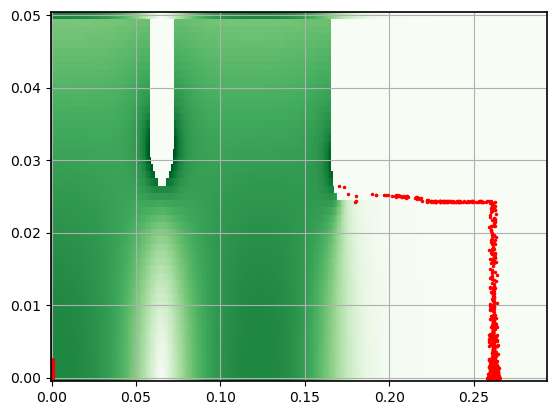

In [ ]:
Z,R = np.meshgrid(zz,rr)
plt.pcolormesh(Z,R,np.transpose(Emag),cmap="Greens")


# ind = endind-4
# print(n)
ind_1 = 119
ind_2 = 0

                # z             #r
plt.plot(pos[:,ind_1,-1],np.sqrt(pos[:,ind_1,0]**2 + pos[:,ind_1,1]**2),'r.',markersize=3,alpha=1)
plt.plot(pos[:,ind_2,-1],np.sqrt(pos[:,ind_2,0]**2 + pos[:,ind_2,1]**2),'r.',markersize=3,alpha=1)
plt.grid()

In [ ]:
print(vel[:,0,0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

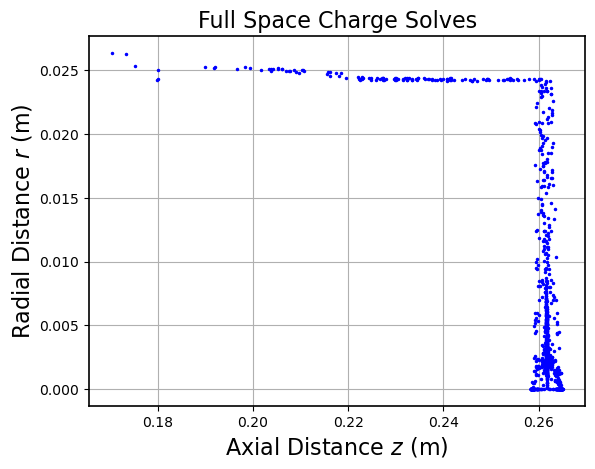

In [ ]:
ind_1 = 0
ind_2 = 119

# plt.plot(pos[:,ind_1,-1],np.sqrt(pos[:,ind_1,0]**2 + pos[:,ind_1,1]**2),'r.',markersize=3,alpha=1)
plt.title("Full Space Charge Solve", fontsize = 16)
plt.xlabel("Axial Distance $z$ (m)", fontsize = 16)
plt.ylabel("Radial Distance $r$ (m)", fontsize = 16)
plt.plot(pos[:,ind_2,-1],np.sqrt(pos[:,ind_2,0]**2 + pos[:,ind_2,1]**2),'b.',markersize=3,alpha=1)
plt.grid()
#plt.plot(pos[:,0,-1]-np.mean(pos[:,0,-1]),np.sqrt(pos[:,0,0]**2 + pos[:,0,1]**2),'b.',markersize=3,alpha=1)

# Nifty Animation

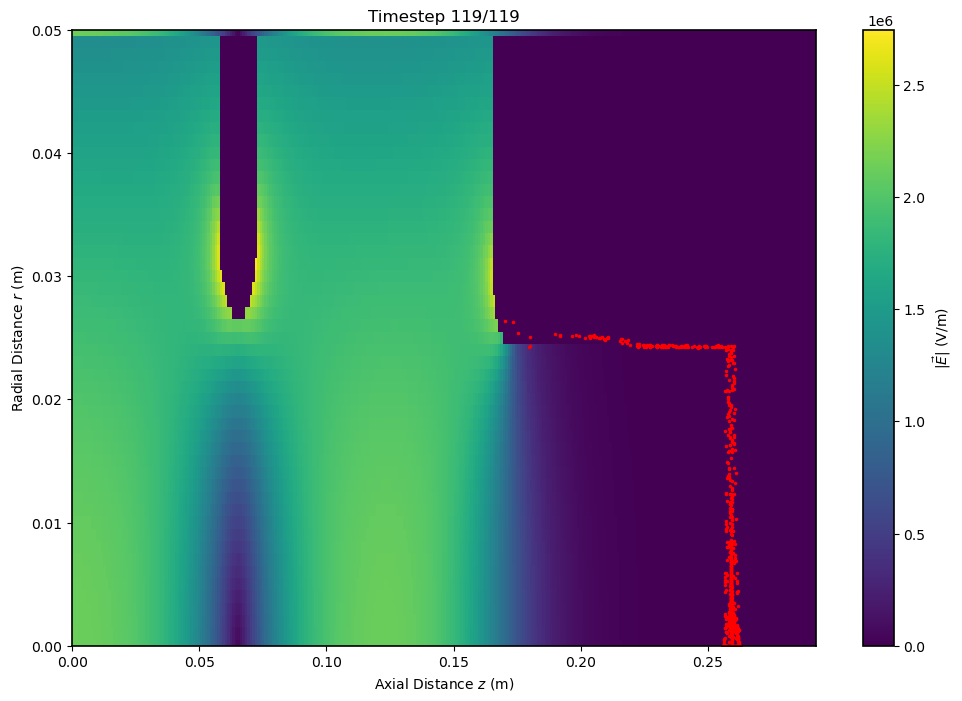

In [ ]:
import matplotlib.animation as animation
import matplotlib.pylab as pylab
from IPython.display import HTML
import datetime

Z, R = np.meshgrid(zz, rr)

fig, ax = plt.subplots(figsize=(12, 8))

# Create the pcolormesh background
c = ax.pcolormesh(Z, R, Emag.T, shading='auto')
cb = fig.colorbar(c, ax=ax, label=r"$|\vec{E}|$ (V/m)")

# Initialize scatter plot for particles
scatter, = ax.plot([], [], 'r.', markersize=3, alpha=1)

ax.set_xlabel("Axial Distance $z$ (m)", fontsize = 16)
ax.set_ylabel("Radial Distance $r$ (m)", fontsize  =16)
title = ax.set_title("")

if CST_FLAG == 1:
    ax.set_xlim(zz[0], zz[-1])
    ax.set_ylim(0, np.max(rr))
else:
    ax.set_xlim(zz[0], zz[-1])
    ax.set_ylim(0, np.max(rr))

# Init function
def init():
    scatter.set_data([], [])
    title.set_text("")
    return scatter, title

endind=119

# Update function for animation
def update(i):
    # Extract positions for frame i
    z_positions = pos[:, i, -1]
    r_positions = np.sqrt(pos[:, i, 0]**2 + pos[:, i, 1]**2)

    scatter.set_data(z_positions, r_positions)
    title.set_text(f"Timestep {i+1}/{endind}")
    return scatter, title

# Create animation
ani = animation.FuncAnimation(
    # NOTE: Hardcoded this to be 150 timesteps to always
    # see the full extent of the animation
    fig, update, frames=endind, init_func=init,
    interval=20, blit=True
)

ani.save(filename=f"superfish{datetime.datetime.now().strftime("%m-%d-%Y:%H-%M-%S")}.gif", writer="pillow")

HTML(ani.to_jshtml())